### Optimizing Rumor Detection: A Dual Feature Extraction Approach with LIME-Based Model Explanation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords, wordnet
# from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import joblib

In [2]:
# dataset link = https://www.kaggle.com/c/fake-news/data

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.shape

(20800, 5)

In [6]:
df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

1 ==> unreliable / rumor / fake

0 ==> reliable / non-rumor / real

Balanced Class Labels

In [7]:
df = df.drop(['id', 'author', 'title'], axis = 1)
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
df.text[100]

'By Patrick Wood By its very nature, the Internet Corporation for Assigned Names and Numbers (ICANN) is a non-profit organization exclusively run by Technocrats. As... '

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


### Null value

In [10]:
df.isnull().sum()

text     39
label     0
dtype: int64

In [11]:
# The forwardfill() method is used to fill in missing values 
# in a DataFrame or Series with the previous valid observation

df['text'].fillna(method='ffill', inplace=True)

In [12]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Duplicate value

In [13]:
df.duplicated().value_counts()

False    20409
True       391
dtype: int64

In [14]:
# dropping Duplicates

df = df.drop_duplicates(keep='first')

In [15]:
df.duplicated().value_counts()

False    20409
dtype: int64

In [16]:
df.shape

(20409, 2)

## Preprocessing

### Data Cleaning

In [17]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [18]:
print(type(stopwords))

<class 'nltk.corpus.reader.wordlist.WordListCorpusReader'>


In [19]:
# print(len(STOPWORDS))

In [20]:
# Ensure you have the necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constants for cleaning
PUNCT_TO_REMOVE = string.punctuation + '“”'
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [21]:
# Combine all cleaning functions
def clean_text(text, FREQWORDS=None, RAREWORDS=None):
    if isinstance(text, str):
        # 1. Convert to lowercase
        text = text.lower()
        
        # 2. Remove punctuation
        text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # 3. Remove hyperlinks, markup, numbers, and special symbols
        text = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', text)
        text = re.sub('&gt;', "", text)  # Greater than sign
        text = re.sub('&#x27;', "'", text)  # Apostrophe
        text = re.sub('&quot;', '"', text)
        text = re.sub('&#x2F;', ' ', text)
        text = re.sub('<p>', ' ', text)  # Paragraph tag
        text = re.sub('<i>', ' ', text)  # Italics tag
        text = re.sub('</i>', '', text)
        text = re.sub('&#62;', '', text)
        text = re.sub("\n", '', text)  # Newline
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r"[’']", "", text)  # Remove special apostrophes

        # 4. Remove stopwords
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        
        # 5. Remove frequent words if provided
        if FREQWORDS:
            text = " ".join([word for word in text.split() if word not in FREQWORDS])
        
        # 6. Remove rare words if provided
        if RAREWORDS:
            text = " ".join([word for word in text.split() if word not in RAREWORDS])
        
        # 7. Lemmatization
        pos_tagged_text = nltk.pos_tag(text.split())
        text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
        
        # 8. Remove URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)
        
    return text

In [22]:
# Apply the cleaning function on the dataset
def preprocess_df(df):
    # Remove URLs, Punctuation, Lowercase, etc. in one go
    df["text"] = df["text"].apply(lambda text: clean_text(text))

    # Get frequent words and remove them
    cnt = Counter()
    for text in df["text"].values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    
    # Get rare words and remove them
    rare_word_count = pd.Series(' '.join(df['text']).split()).value_counts()[-2:]
    RAREWORDS = list(rare_word_count.index)
    
    # Apply removal of frequent and rare words
    df["text"] = df["text"].apply(lambda text: clean_text(text, FREQWORDS=FREQWORDS, RAREWORDS=RAREWORDS))

    return df

In [23]:
# Use the function to clean and preprocess the dataframe
df = preprocess_df(df)
df.head()

,text,label
0,house dem aide didnt even see comeys letter ja...,1
1,ever get feeling life circle roundabout rather...,0
2,truth might get fired october tension intellig...,1
3,video civilian kill single u airstrike identif...,1
4,print iranian woman sentence six prison iran r...,1


#### After Preprocessing: 

In [24]:
df.text[100]

'patrick wood nature internet corporation assign name number icann nonprofit organization exclusively run technocrat'

In [25]:
df.shape

(20409, 2)

In [26]:
df.label.value_counts()

0    10387
1    10022
Name: label, dtype: int64

## Split Data

In [27]:
X = df['text']  # Features
y = df['label'] # Target

In [28]:
print(X[:1])

0    house dem aide didnt even see comeys letter ja...
Name: text, dtype: object


In [29]:
print(y)

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20409, dtype: int64


### Feature Extraction

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Custom parameters for CountVectorizer
count_vect = CountVectorizer(max_features=10000, ngram_range=(1, 2))

# Custom parameters for TfidfVectorizer
# tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [31]:
# Apply CountVectorizer
X_count = count_vect.fit_transform(X)


# Apply TfidfVectorizer
# X_tfidf = tfidf_vect.fit_transform(X)

In [32]:
# Example of correct data splitting
# X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=42)
# X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [33]:
# print(f"X_train_count shape: {X_train_count.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test_count shape: {X_test_count.shape}")
# print(f"y_test shape: {y_test.shape}")

# print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
# print(f"y_train shape: {y_test.shape}")

## Model Training - CountVectorizer

### 1. Logistic Regression

In [36]:
# Initialize Logistic Regression model
log_reg_count = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0, penalty='l2')

# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    log_reg_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = log_reg_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9418
Mean F1 Score: 0.9410
Mean Precision: 0.9360
Mean Recall: 0.9461

=== Final Summed Confusion Matrix Across All Folds ===
[[9739  648]
 [ 540 9482]]


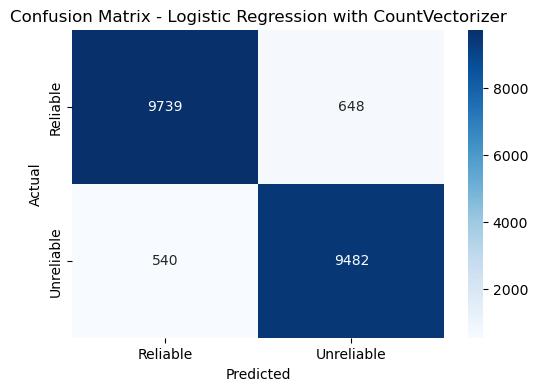

In [37]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(log_reg_count, 'logistic_regression_model_count0.pkl')

### 2. Naive Bayes

In [38]:
# Initialize the Naive Bayes model
naive_bayes_count = MultinomialNB(alpha=1.0, fit_prior=True)

# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    naive_bayes_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = naive_bayes_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.8830
Mean F1 Score: 0.8750
Mean Precision: 0.9207
Mean Recall: 0.8336

=== Final Summed Confusion Matrix Across All Folds ===
[[9668  719]
 [1668 8354]]


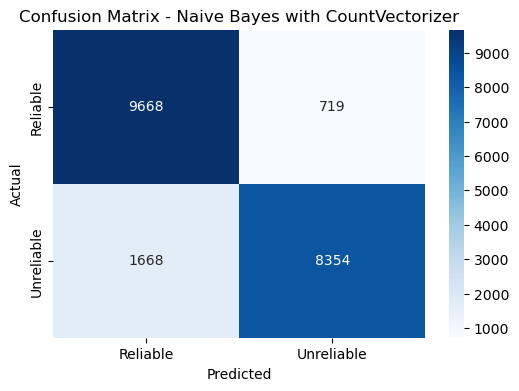

In [39]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(naive_bayes_count, 'naive_bayes_model_count.pkl')

### 3. Stochastic Gradient Descent (SGD)

In [50]:
# Initialize the Stochastic Gradient Descent (SGD) Classifier
sgd_count = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, tol=1e-3, random_state=42)

# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    sgd_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = sgd_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9334
Mean F1 Score: 0.9330
Mean Precision: 0.9223
Mean Recall: 0.9440

=== Final Summed Confusion Matrix Across All Folds ===
[[9588  799]
 [ 561 9461]]


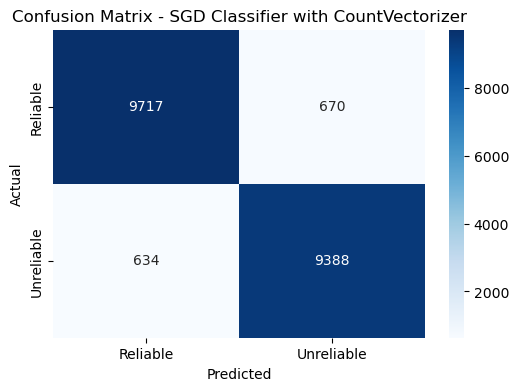

In [41]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SGD Classifier with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(sgd_count, 'stochastic_gradient_descent_model_count.pkl')

### 4. K-Nearest Neighbors (KNN)

In [42]:
# Initialize the KNN model
knn_count = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # p=2 means Euclidean distance

# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    knn_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.6929
Mean F1 Score: 0.7538
Mean Precision: 0.6216
Mean Recall: 0.9574

=== Final Summed Confusion Matrix Across All Folds ===
[[4547 5840]
 [ 427 9595]]


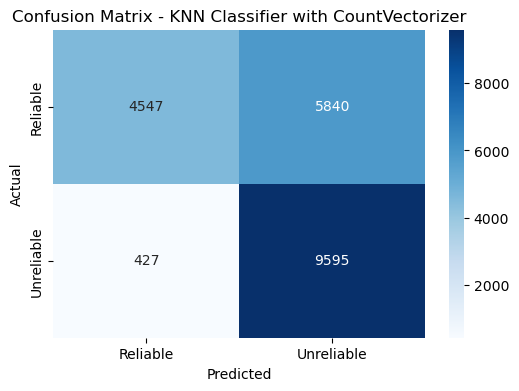

In [43]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - KNN Classifier with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(knn_count, 'k-nearest_neighbors_model_count.pkl')

### 5. Decision Tree

In [44]:
# Initialize the Decision Tree model
decision_tree_count = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=42)

# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    decision_tree_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = decision_tree_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.8362
Mean F1 Score: 0.8335
Mean Precision: 0.8324
Mean Recall: 0.8347

=== Final Summed Confusion Matrix Across All Folds ===
[[8702 1685]
 [1657 8365]]


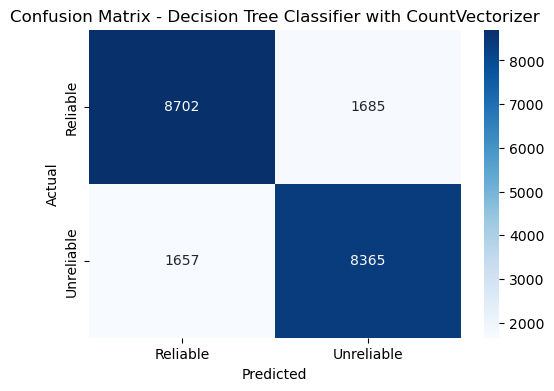

In [45]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Tree Classifier with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(decision_tree_count, 'decision_tree_model_count.pkl')

### 6. Random Forest

In [46]:
# Initialize the Random Forest model
random_forest_count = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42, n_jobs=-1)


# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # Assuming binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    random_forest_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = random_forest_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9192
Mean F1 Score: 0.9155
Mean Precision: 0.9408
Mean Recall: 0.8914

=== Final Summed Confusion Matrix Across All Folds ===
[[9825  562]
 [1088 8934]]


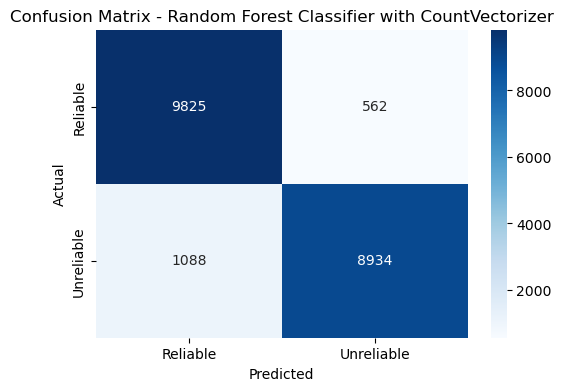

In [47]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest Classifier with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(random_forest_count, 'random_forest_model_count.pkl')

### 7. Support Vector Machine (SVM)

In [48]:
# Initialize the Support Vector Machine model with a linear kernel
svm_count = SVC(kernel='linear', C=1.0, random_state=42)


# Initialize k-fold cross-validation

kf = StratifiedKFold(n_splits= 5, shuffle=True)

# Initialize metrics to accumulate results
conf_matrix_sum = np.zeros((2, 2))  # for binary classification (2x2 confusion matrix)

# Lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_count, y)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and testing sets for this fold using .iloc for positional indexing
    X_train, X_test = X_count[train_index], X_count[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Use iloc to select by position
    
    # Fit the logistic regression model
    svm_count.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = svm_count.predict(X_test)
    
    # Update confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_sum += conf_matrix  # Accumulate the confusion matrices
    
     # Calculate and store metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))



# Print the final averaged metrics
print("\n=== Final Averaged Metrics Across All Folds ===")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')

# Print the final summed confusion matrix
print("\n=== Final Summed Confusion Matrix Across All Folds ===")
print(conf_matrix_sum.astype(int))  # Convert to integer for cleaner display

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

=== Final Averaged Metrics Across All Folds ===
Mean Accuracy: 0.9292
Mean F1 Score: 0.9285
Mean Precision: 0.9217
Mean Recall: 0.9353

=== Final Summed Confusion Matrix Across All Folds ===
[[9591  796]
 [ 648 9374]]


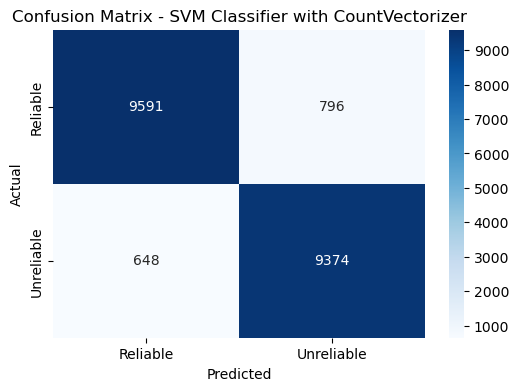

In [49]:
# Plot confusion matrix
conf_matrix = conf_matrix_sum.astype(int)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM Classifier with CountVectorizer')
plt.show()

In [ ]:
# Save the trained model to a file

# joblib.dump(svm_count, 'svm_model_count.pkl')